# Get the Scale and Zero Point | Linear Quantization

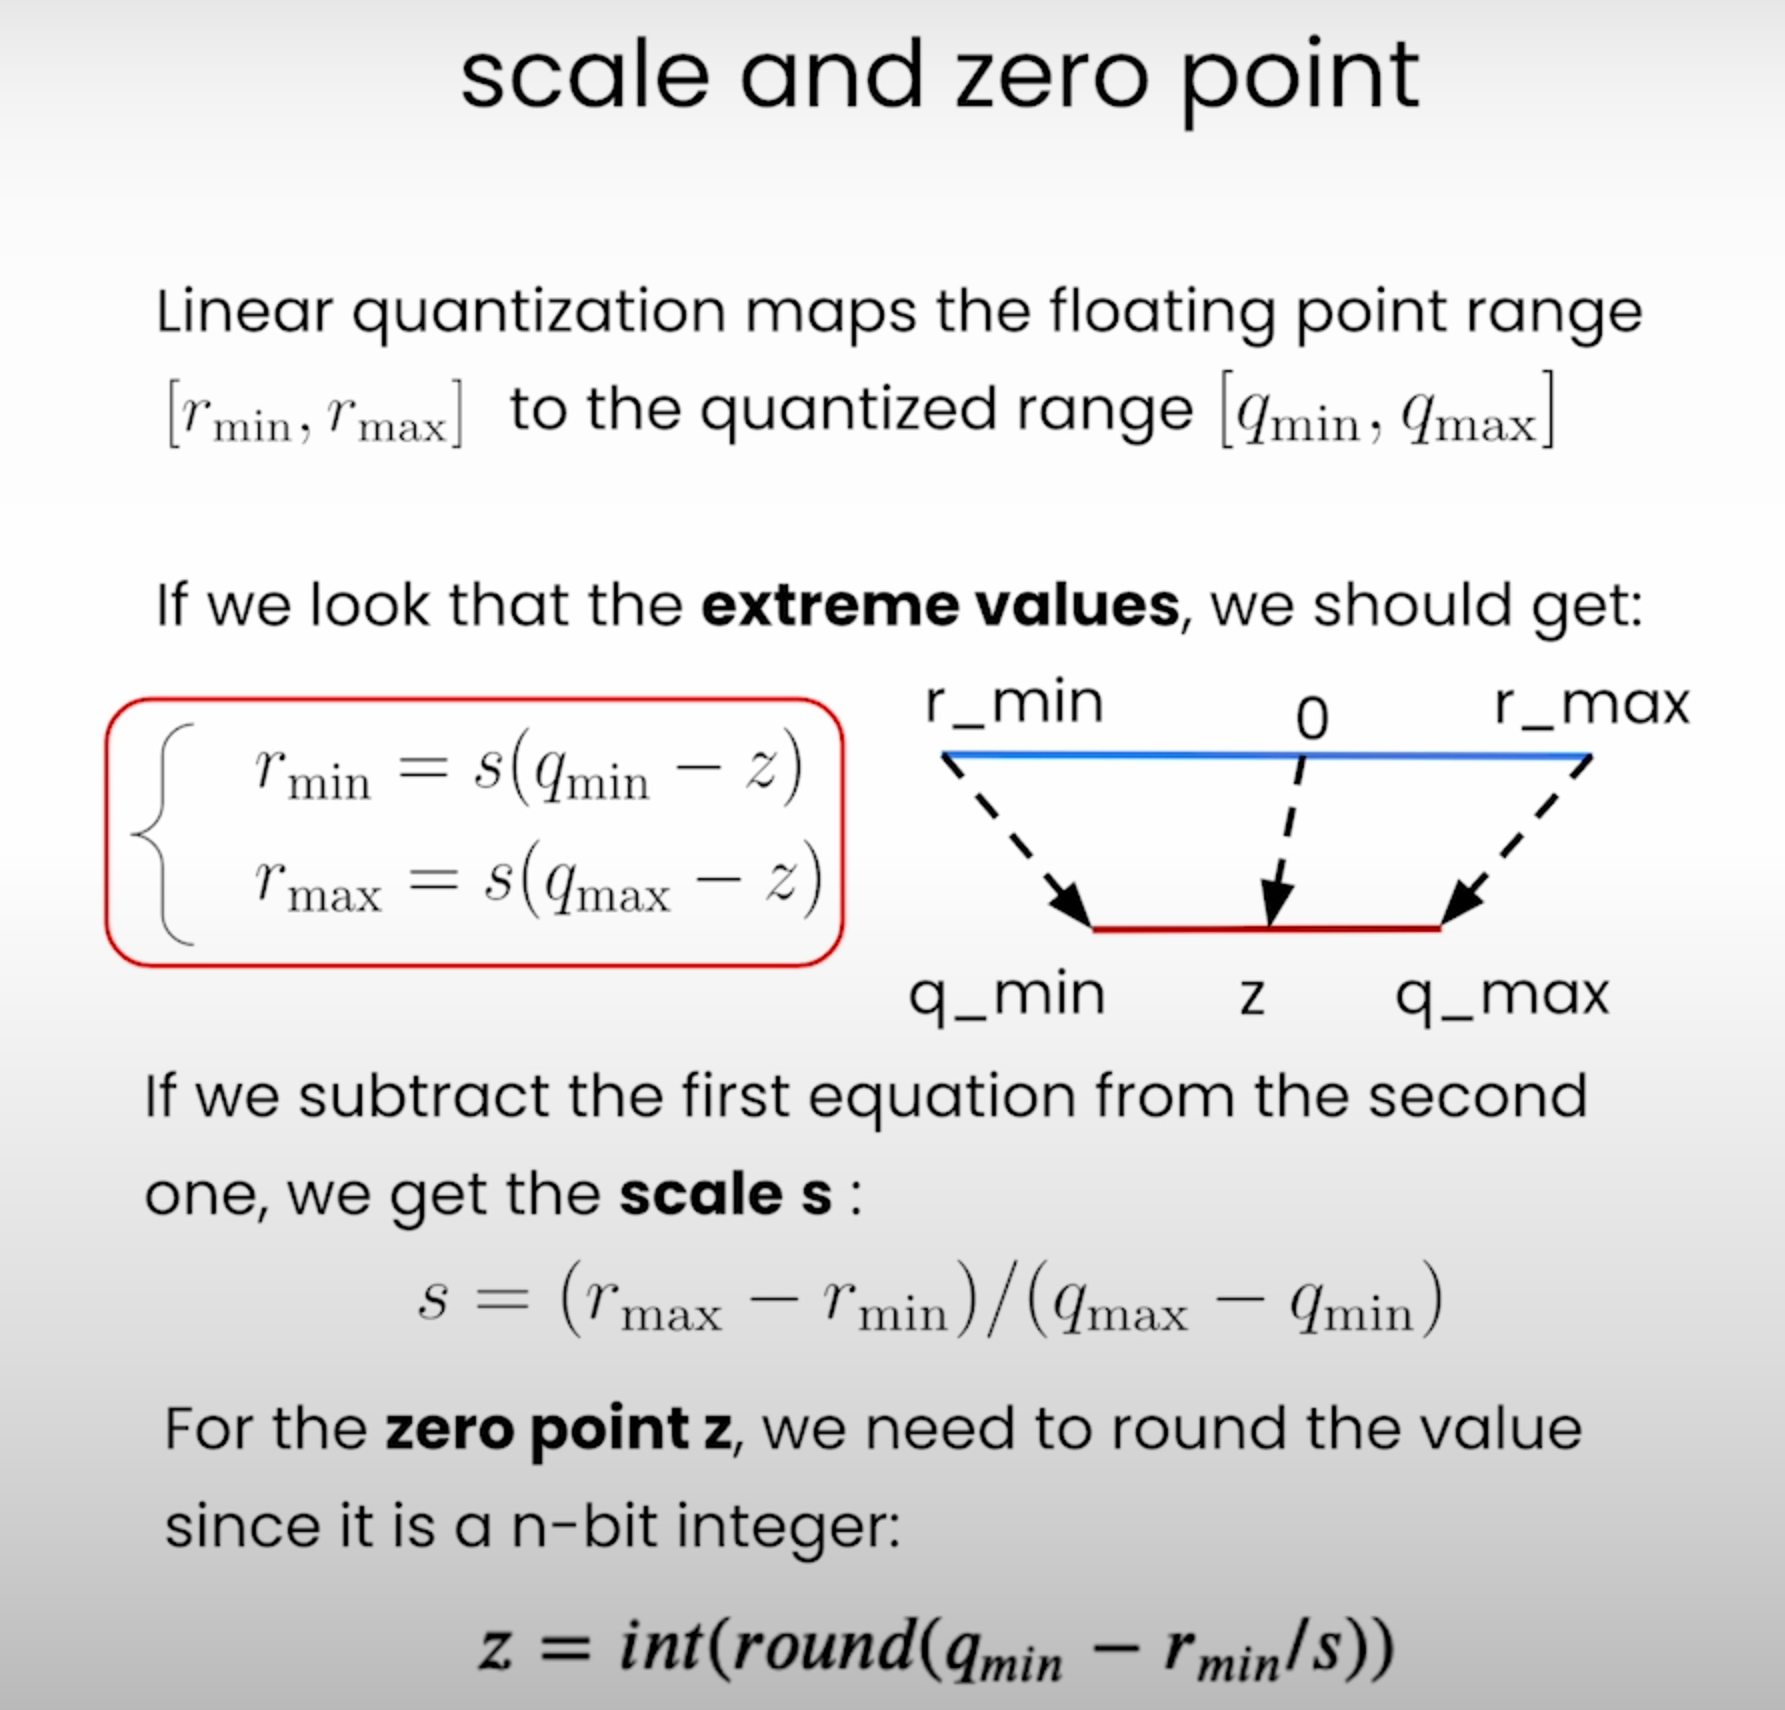

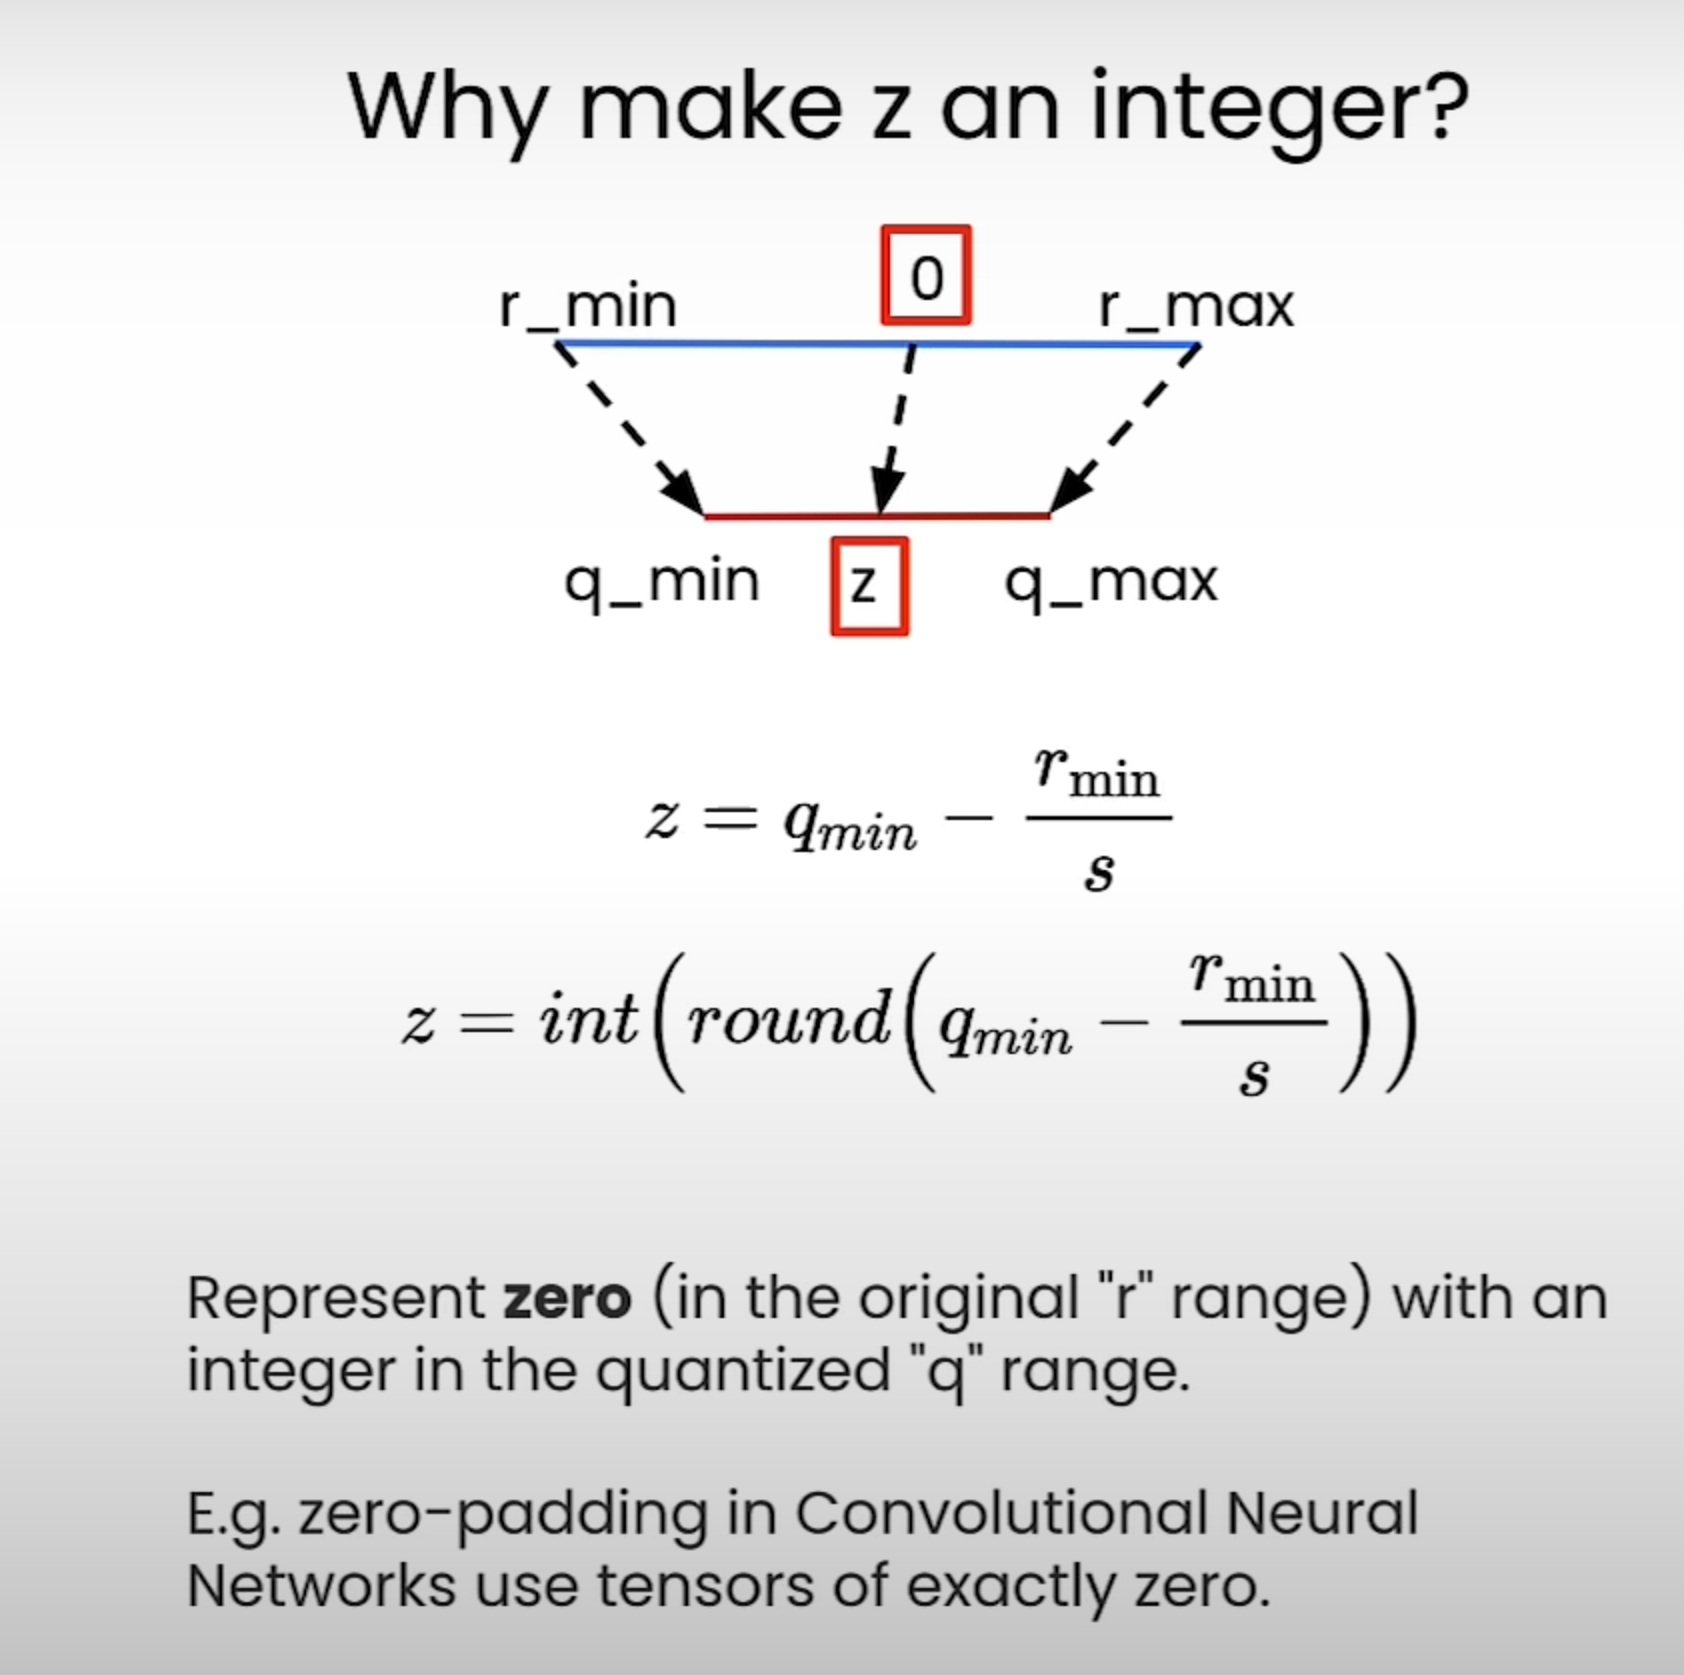

In [1]:
import torch

from helper1 import linear_q_with_scale_and_zero_point, linear_dequantization, plot_quantization_errors

### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

## Finding `Scale` and `Zero Point` for Quantization

In [2]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [3]:
q_min

-128

In [4]:
q_max

127

In [5]:
# r_min = test_tensor.min()
r_min = test_tensor.min().item()

In [6]:
r_min

-184.0

In [7]:
# r_max = test_tensor.min()
r_max = test_tensor.max().item()

In [8]:
r_max

728.5999755859375

In [11]:
scale = (r_max -r_min) / (q_max - q_min)

In [12]:
scale

3.578823433670343

In [13]:
zero_point = q_min - (r_min / scale)

In [14]:
zero_point

-76.58645490333825

- Now, put all of this in a function.

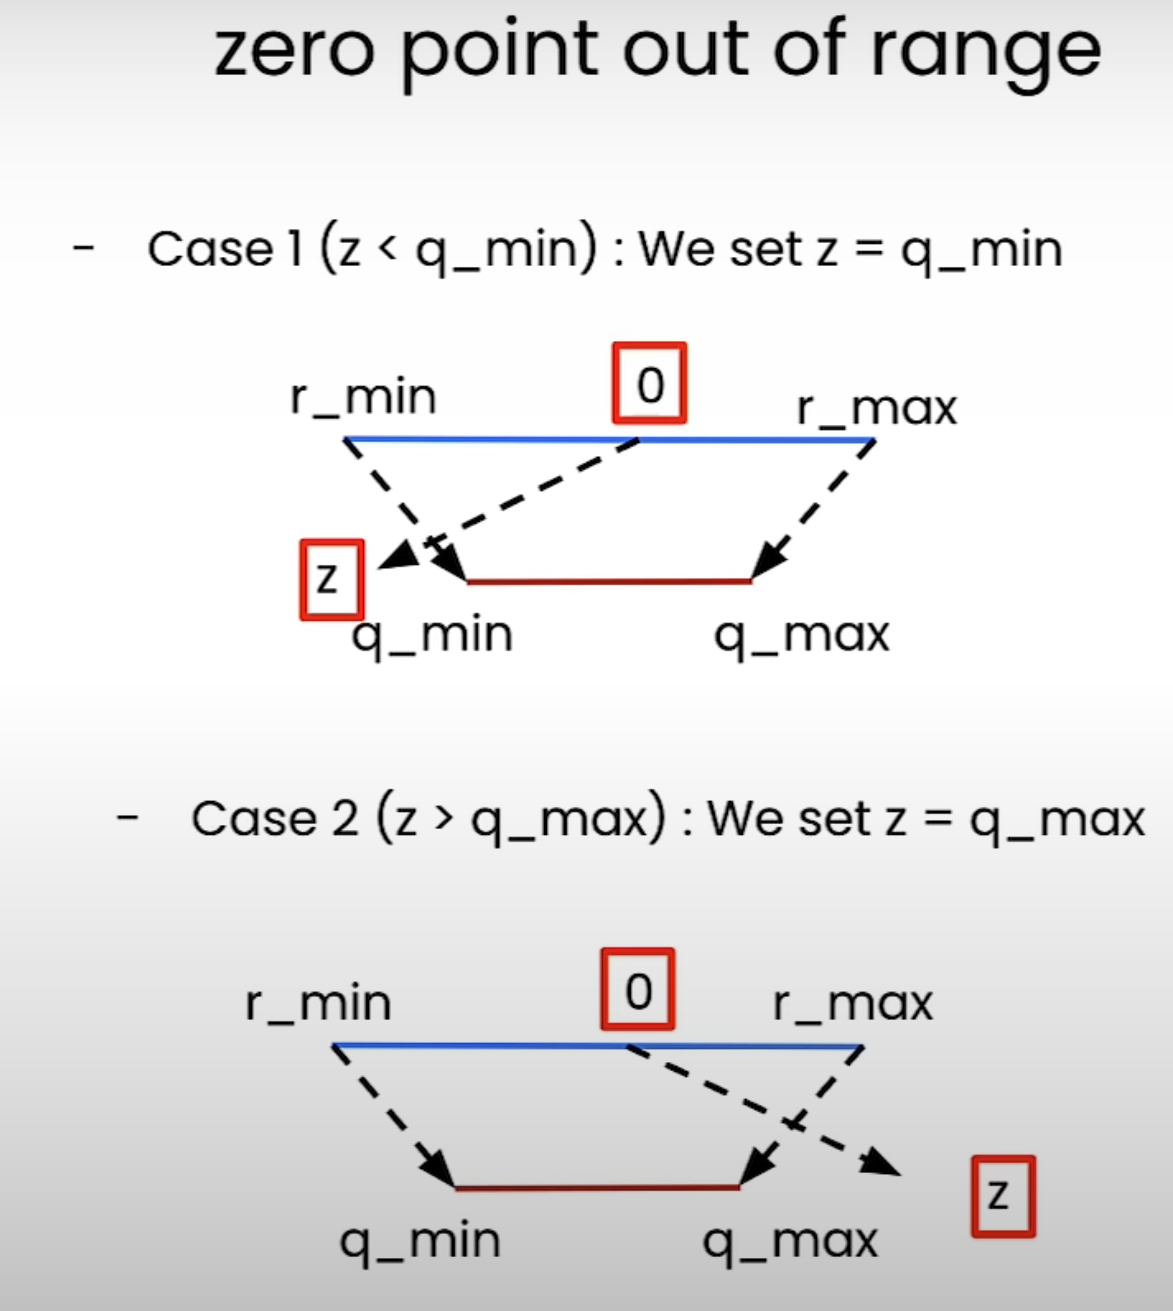

In [21]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max -q_min)

    zero_point = q_min - (r_min / scale)
    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [22]:
new_scale, new_zero_point = get_q_scale_and_zero_point(
    test_tensor)

In [23]:
new_scale

3.578823433670343

In [24]:
new_zero_point

-77

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [26]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, new_scale, new_zero_point)

In [27]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           new_scale, new_zero_point)

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

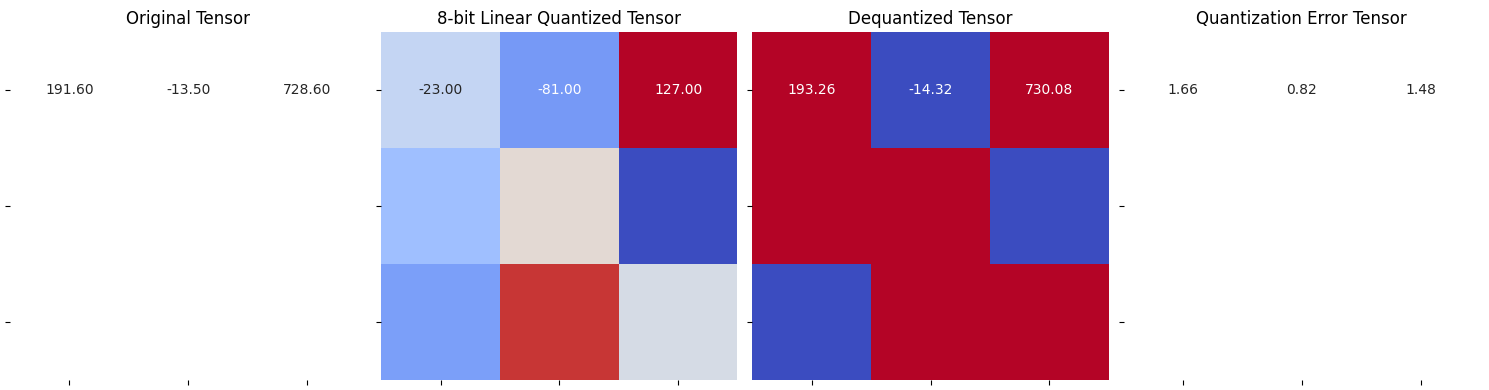

In [29]:
plot_quantization_errors(test_tensor, quantized_tensor, 
                         dequantized_tensor)

In [30]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [31]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, 
                                                   dtype=dtype)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale, 
                                                          zero_point, 
                                                          dtype=dtype)
    
    return quantized_tensor, scale , zero_point

- Test your implementation on a random matrix.

In [32]:
r_tensor = torch.randn((5, 4))

In [33]:
r_tensor

tensor([[ 1.0416,  1.3252, -1.3415,  0.5904],
        [-1.1303, -0.3877,  0.2466, -0.6932],
        [ 1.6021,  0.1058, -2.4796,  1.0029],
        [-0.2033,  1.3813, -0.0634,  0.2251],
        [ 0.4665,  1.1943, -0.2711,  1.2243]])

In [34]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [35]:
quantized_tensor

tensor([[  92,  110,  -57,   64],
        [ -44,    3,   42,  -16],
        [ 127,   34, -128,   90],
        [  14,  113,   23,   41],
        [  56,  102,   10,  103]], dtype=torch.int8)

In [36]:
scale

0.016006704405242322

In [37]:
zero_point

27

In [38]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

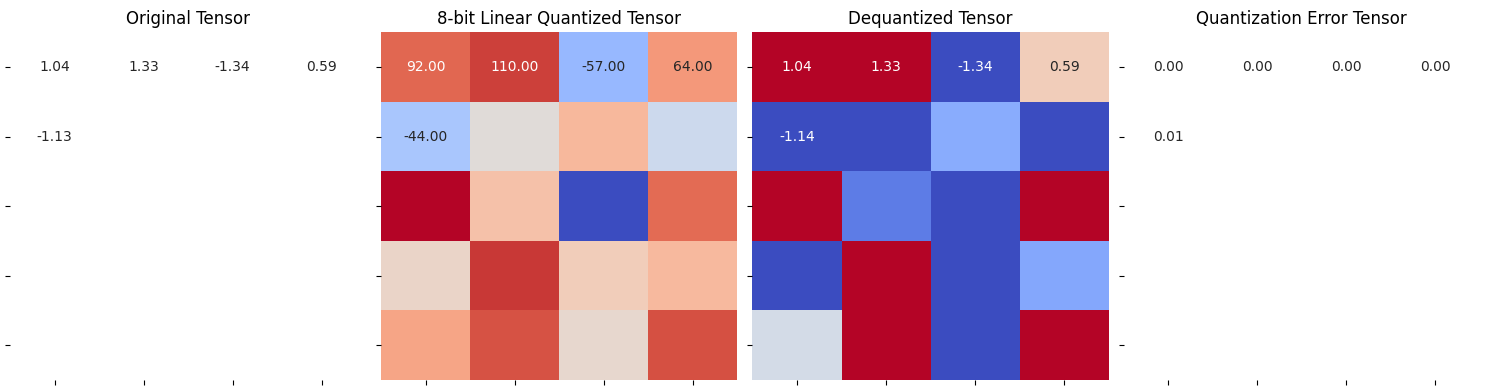

In [39]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

In [40]:
(dequantized_tensor-r_tensor).square().mean()

tensor(1.8403e-05)